<a href="https://www.kaggle.com/code/catalystcooperative/03-eia-930-sanity-checks?scriptVersionId=235662903" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imputed Hourly Demand in PUDL
## Background
PUDL data includes multiple sources for hourly electricity demand data reported at various levels of spatial granularity. Namely, [FERC Form 714](https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/ferc714.html) contains hourly demand by planning area, while [EIA Form 930](https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/eia930.html) contains hourly demand by Balancing Authority (BA) and BA subregion. In order to make this data more readily usable for cases which value completeness and smoothness of the data, we've developed a pipeline for imputing missing and anomolous data points.

Our imputation pipeline is adapted from this [implementation](https://github.com/truggles/EIA_Cleaned_Hourly_Electricity_Demand_Code) by [Tyler Ruggles](https://github.com/truggles) and [Alicia Wongel](https://github.com/awongel). We also worked with Alicia to test and validate our work along the way. Despite the reference implementation being specifically developed for EIA 930, we initially adapted it for FERC 714 data, and only recently generalized our implementation to work with EIA 930 data. During this generalization process, we standardized how we structure and naming conventions for imputed data, and developed significant tooling for analyzing and validating the data. This notebook will demonstrate how to access this data, and what we've done to feel confident in our imputation. For a detailed description of our timeseries imputation methods, see the [docs](https://catalystcoop-pudl.readthedocs.io/en/latest/methodology/timeseries_imputation.html).

## Available Data
### General
- `core_pudl__codes_imputation_reasons` - Describes reasons a value was "flagged" for imputation

### FERC Form 714
- `out_ferc714__hourly_planning_area_demand` - Hourly demand by planning area

### EIA Form 930
- `out_eia930__hourly_operations` - Hourly demand by BA
- `out_eia930__hourly_subregion_demand` - Hourly subregion demand

## Approach to Validating Performance
When imputing data it can be difficult to validate the performance as the data we are imputing is inherently "bad", and so we will never know what the true values should be. To deal with this limitation, we've applied several different approaches to validation, which we use in conjunction to feel confident in our implementation.

### The Eye Test
The first step to validation is to simply visually inspect sections of data to look for obvious issues. To do this, we plot sections of data and visually compare the imputed and reported data. While this is a basic approach it's an incredibly valuable way to quickly assess performance and check intuitive expectations.

### Compare to Baseline"
Our second approach is to compare our results to the baseline implementation linked above. Since we have an existing example of imputed EIA 930 data, we are able to use this as a comparison for our results. This, of course, assumes the original implementation is performing well, but it at least gives confidence that we have not significantly diverged from this reference.

### Impute Simulated Data
Finally, we have developed a simulation pipeline, which provides a more quantitative approach to validating performance. This approach finds sections of data where no values were flagged for imputation, and flags a number of these for a simulated imputation. This way, we can impute values where we have a ground truth for comparison.

## Notebook Setup

In [1]:
!pip install matplotx --quiet

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import requests
import zipfile
from io import BytesIO

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
import matplotx
from pandas.tseries.offsets import MonthEnd

matplotlib.style.use(matplotx.styles.onedark)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Data Access
 All of the tables listed above are available in PUDL nightly builds, and will be updated with new data as it becomes available. All of these tables can be accessed as a parquet file from a link like:

```
s3://pudl.catalyst.coop/nightly/{table_name}.parquet
```

Below we'll demonstrate loading a table from nightly builds into a Pandas DataFrame with the `core_pudl__codes_imputation_reasons` table.

In [4]:
def get_s3_nightly(table: str) -> pd.DataFrame:
    """Read data from our AWS open data registry S3 bucket."""
    return pd.read_parquet(f"s3://pudl.catalyst.coop/nightly/{table}.parquet")

get_s3_nightly("core_pudl__codes_imputation_reasons")

,code,description
0,missing_value,Indicates that reported value was already NULL.
1,anomalous_region,Indicates that value is surrounded by flagged ...
2,negative_or_zero,Indicates value is negative or zero.
3,identical_run,Indicates value is part of an identical run of...
4,global_outlier,Indicates value is greater or less than n time...
5,global_outlier_neighbor,Indicates value neighbors global outliers.
6,local_outlier_high,Indicates value is a local outlier on the high...
7,local_outlier_low,Indicates value is a local outlier on the low ...
8,double_delta,Indicates value is very different from neighbo...
9,single_delta,Indicates value is significantly different fro...


## Visualizing Imputed Data
An important part of the development process when creating our imputation pipeline was visual spot checking of imputed data. This allows us to qualitatively judge performance when it is often difficult to impossible to produce quantitative measurements. We'll implement a function below to identify sections of data where a relatively high proportion of values were flagged. By default this function will look for months of data where between 10-25% of values were flagged. This range tends to be interesting, as there's enough "bad" values to challenge the imputation, but not so many that there's insufficient "good" data for reference.

Next, we'll implement a function to actual plot the interesting regions of data we identify. This function will take a set of ID's to identify a specific BA or subregion, and a date range to plot.

### Identify regions of interest

In [5]:
def get_imputation_rate(
    df: pd.DataFrame,
    idx_cols: list[str],
    flag_col: str = "demand_imputed_pudl_mwh_imputation_code",
    min_imputation_rate: float = 0.1,
    max_imputation_rate: float = 0.25,
    num_samples: int = 2,
    time_period: str | None = "month",
) -> pd.DataFrame:
    """Function to identify months with a relatively high rate of imputation.

    Args:
        df: DataFrame with imputed demand.
        id_cols: Set of columns that identify a unique respondent.
        flag_col: Column describing if/why row was selected for imputation.
        min_imputation_rate: Minimum ratio of values in month that were imputed.
        max_imputation_rate: Maximum ratio of values in month that were imputed (too high and
            the performance is no longer interesting as there's insufficient underlying data to reference).
        num_samples: Number of months to return. If 0, return all months with specified range.
        time_period: Return imputation rate by period. Accepted values are 'month' or 'year'. If None
            return imputation rate across entire timeframe
    """
    # 2025 is incomplete and distorts results
    df = df[df.datetime_utc.dt.year < 2025]

    groups = [*idx_cols]
    if time_period == "month":
        groups.append(pd.Grouper(key="datetime_utc", freq="MS"))
    elif time_period == "year":
        groups.append(pd.Grouper(key="datetime_utc", freq="YE"))

    imputation_rate = (
        (
            df.groupby(
                groups, observed=True
            )[flag_col].apply(lambda x: x.notnull().mean())
        )
        .reset_index()
        .rename(columns={flag_col: "imputation_rate", "datetime_utc": time_period})
        .sort_values(by=["imputation_rate"], ascending=False)
    )
    filtered_rate = imputation_rate[
        (imputation_rate.imputation_rate >= min_imputation_rate) &
        (imputation_rate.imputation_rate <= max_imputation_rate)
    ]
    if num_samples > 0:
        filtered_rate = filtered_rate.sample(num_samples, random_state=2)
    return filtered_rate

### Plot regions of interest

In [24]:
from typing import Any

# Implement helper function to select a range of data
# This will be used throughout the notebook
def _filter_df(
    df: pd.DataFrame,
    idx_cols: list[str],
    idx_vals: tuple[Any],
    start_date: str | None = None,
    end_date: str | None = None,
    time_col: str = "datetime_utc",
) -> pd.DataFrame:
    """Filter a dataframe based on index columns and date range."""
    if start_date is None:
        start_date = df[time_col].min()
    if end_date is None:
        end_date = df[time_col].max()
    return (
        df.set_index(idx_cols + [time_col])
        .sort_index()
        .loc[idx_vals]
        .loc[start_date:end_date]
    )


def plot_imputation(
    df: pd.DataFrame,
    idx_cols: list[str],
    idx_vals: tuple[Any],
    start_date: str,
    end_date: str,
    reported_col: str,
    imputed_col: str,
    time_col: str = "datetime_utc",
    ylabel: str = "Demand [MWh]",
):
    """Compare reported values with imputed values visually.

    Select a particular time series based on the ID columns and limit the data displayed
    based on the provided start and end dates. Plot both the reported and imputed
    values, color coding imputed values based on the reason for imputation.

    """
    # Set the dataframe index to the ID columns and the time column
    # Select specified index values that fall within the specified date range:
    filtered = _filter_df(df, idx_cols, idx_vals, start_date, end_date, time_col)
    plt.figure(figsize=(12, 6))
    plt.plot(
        filtered.index,
        filtered[reported_col],
        lw=1,
        color="gray",
        label="reported",
        alpha=0.5,
    )
    plt.plot(filtered.index, filtered[imputed_col], lw=1, label="imputed")
    imputation_code_col = imputed_col + "_imputation_code"
    for code in filtered[filtered[imputation_code_col].notnull()][imputation_code_col].unique():
        mask = filtered[imputed_col + "_imputation_code"] == code
        plt.scatter(
            filtered.index[mask],
            filtered[imputed_col][mask],
            label=code,
            s=3,
            alpha=0.9,
        )
    plt.title(f"Reported vs Imputed Values for {idx_vals}")
    plt.ylabel(ylabel)
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        borderaxespad=0.0,
        markerscale=2,  # Scale up the marker size in the legend
    )
    plt.tight_layout()  # Adjust layout to make room for the legend
    plt.show()


### EIA 930 Subregion Demand
We'll start with EIA 930 subregion demand using the function above to find months of interest. We'll start by grabbing a collection of months, then choosing a few to plot for demonstration purposes.

In [25]:
# Load imputed subregion demand table from nightly builds
eia930_subregion_demand = get_s3_nightly("out_eia930__hourly_subregion_demand")

# Find months with a high rate of imputation
subregion_idx_cols = ["balancing_authority_code_eia", "balancing_authority_subregion_code_eia"]
subregion_months_of_interest = get_imputation_rate(eia930_subregion_demand, idx_cols=subregion_idx_cols, num_samples=10)
subregion_months_of_interest

,balancing_authority_code_eia,balancing_authority_subregion_code_eia,month,imputation_rate
5216,SWPP,LES,2021-08-01,0.198925
4887,SWPP,EDE,2024-03-01,0.205645
5483,SWPP,OPPD,2019-11-01,0.229167
4568,PNM,LAC,2023-12-01,0.243280
5864,SWPP,WFEC,2021-08-01,0.198925
5936,SWPP,WR,2021-08-01,0.198925
4561,PNM,LAC,2023-05-01,0.192204
5620,SWPP,SPRM,2019-04-01,0.119444
4814,SWPP,CSWS,2024-02-01,0.147989
5190,SWPP,LES,2019-06-01,0.188889


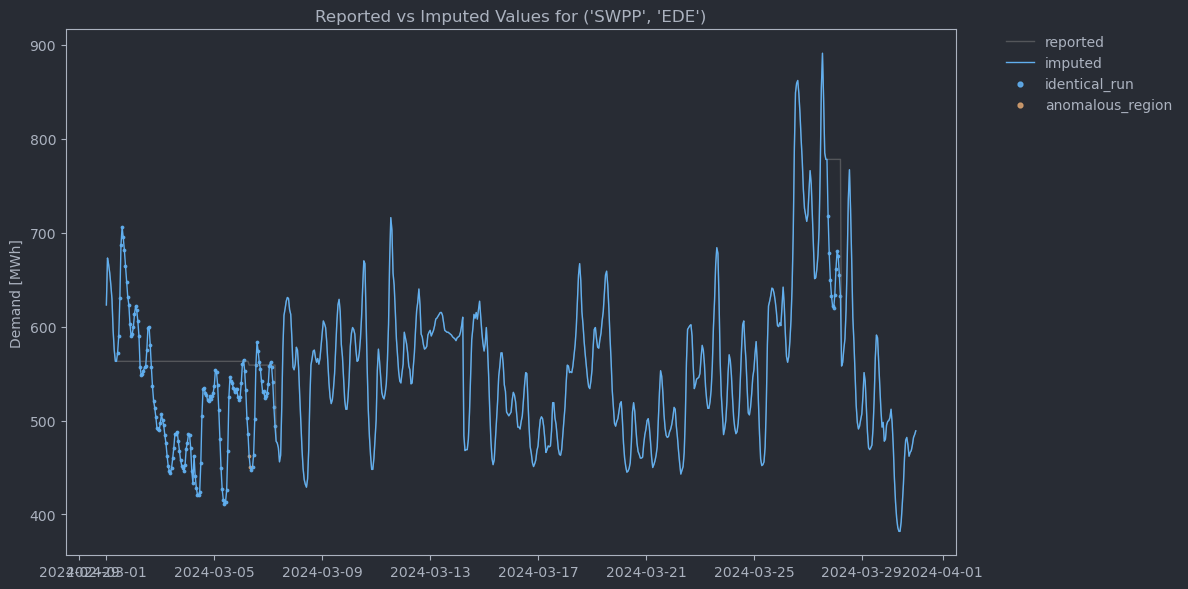

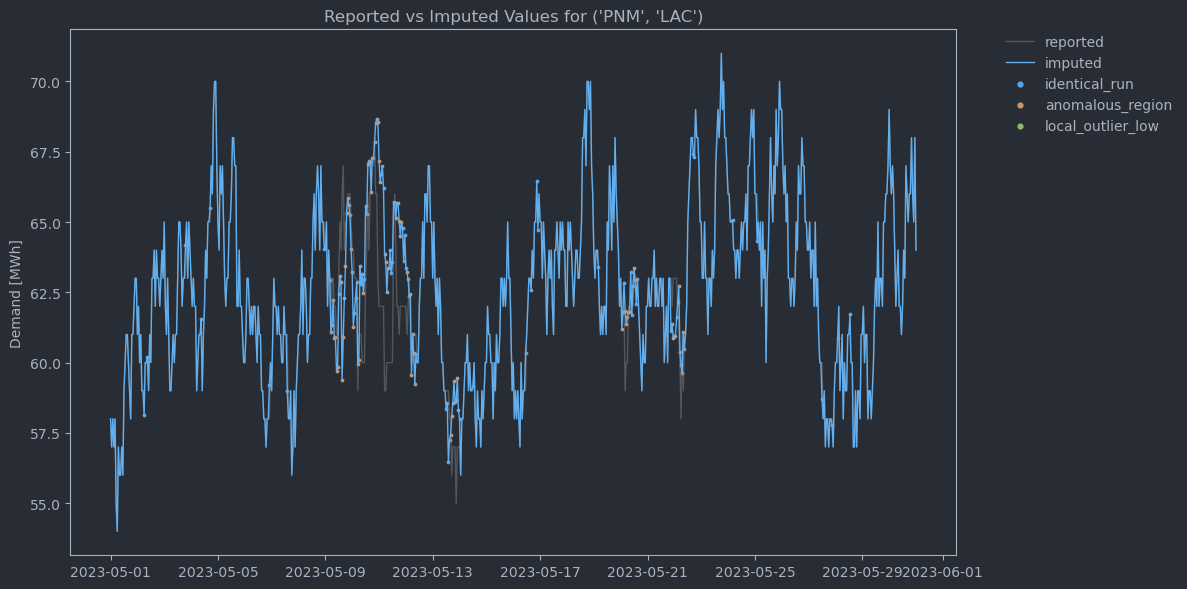

In [26]:
for month, subregion_idx_vals in [
    ("2024-03-01", ("SWPP", "EDE")),
    ("2023-05-01", ("PNM", "LAC")),
]:
    plot_imputation(
        eia930_subregion_demand,
        idx_cols=subregion_idx_cols,
        idx_vals=subregion_idx_vals,
        start_date=month,
        end_date=pd.Timestamp(month) + MonthEnd(),
        reported_col="demand_reported_mwh",
        imputed_col="demand_imputed_pudl_mwh",
    )

In these sections we can see several common features of the reported data that lead to flagging. For example, in the first plot, we see a large unnaturally flat section of reported data where the same value is repeated for many hours. We flag these sections as `identical_run`s.

The second plot contains many `identical_run`'s, but the behavior is somewhat different. Here we see many smaller flat sections grouped together in a relatively short timespan. When we see a number of sections of flagged data grouped together like this, we end up flagging the intermediate values between these sections as `anomolous_region`s. This indicates that while these data points themselves don't appear obviously anomolous, we have lower trust given to their association with questionable surrounding data. In this specific case, it could be argued that these `anomolous_region`s don't look too bad, and we could try to tune the thresholds we use for identifying an `anomolous_region` so these values don't end up getting flagged. Ultimately, however, this is a necessary limitation of performing imputation at this scale as we must make tradeoffs between never flagging values that might be reasonable and missing values that are obviously wrong.

The second plot also presents a challenge with using plots like this, as the information density can be quite high making it difficult to interpret exactly what is happening here. To supplement the plot, it can also be useful to look at a selection of raw data, which we'll demonstrate below.

In [10]:
(
    eia930_subregion_demand.set_index(subregion_idx_cols + ["datetime_utc"])
    .sort_index()
    .loc[("PNM", "LAC")]
    .loc["2023-05-10 09:00:00":"2023-05-11 12:00:00"]
)

,demand_reported_mwh,demand_imputed_pudl_mwh,demand_imputed_pudl_mwh_imputation_code
datetime_utc,,,
2023-05-10 09:00:00,60.0,63.138573,anomalous_region
2023-05-10 10:00:00,60.0,62.466602,anomalous_region
2023-05-10 11:00:00,60.0,62.966835,identical_run
2023-05-10 12:00:00,63.0,65.576546,anomalous_region
2023-05-10 13:00:00,64.0,65.281517,anomalous_region
2023-05-10 14:00:00,66.0,67.054123,anomalous_region
2023-05-10 15:00:00,64.0,67.185669,anomalous_region
2023-05-10 16:00:00,66.0,67.139816,anomalous_region
2023-05-10 17:00:00,67.0,66.063278,anomalous_region


### EIA 930 BA Demand
Now we will repeat this process with EIA 930 BA demand.

In [11]:
# Load imputed subregion demand table from nightly builds
eia930_ba_demand = get_s3_nightly("out_eia930__hourly_operations")

# Find months with a high rate of imputation
ba_idx_cols = ["balancing_authority_code_eia"]
ba_months_of_interest = get_imputation_rate(eia930_ba_demand, idx_cols=ba_idx_cols, num_samples=10)
ba_months_of_interest

,balancing_authority_code_eia,month,imputation_rate
4256,PACE,2017-03-01,0.173387
5407,SEC,2018-02-01,0.184524
3637,LGEE,2021-03-01,0.137097
4249,PACE,2016-08-01,0.190860
5403,SEC,2017-10-01,0.201613
4237,PACE,2015-08-01,0.107527
4250,PACE,2016-09-01,0.244444
2111,FPL,2022-01-01,0.186828
4225,OVEC,2018-02-01,0.104167
3939,NSB,2017-11-01,0.206944


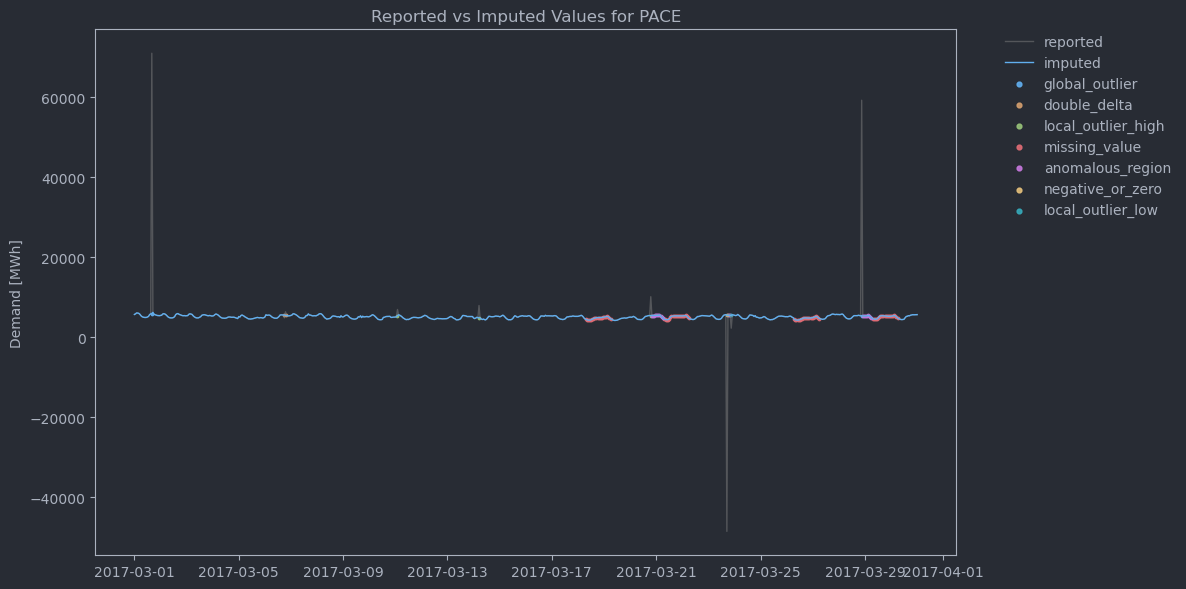

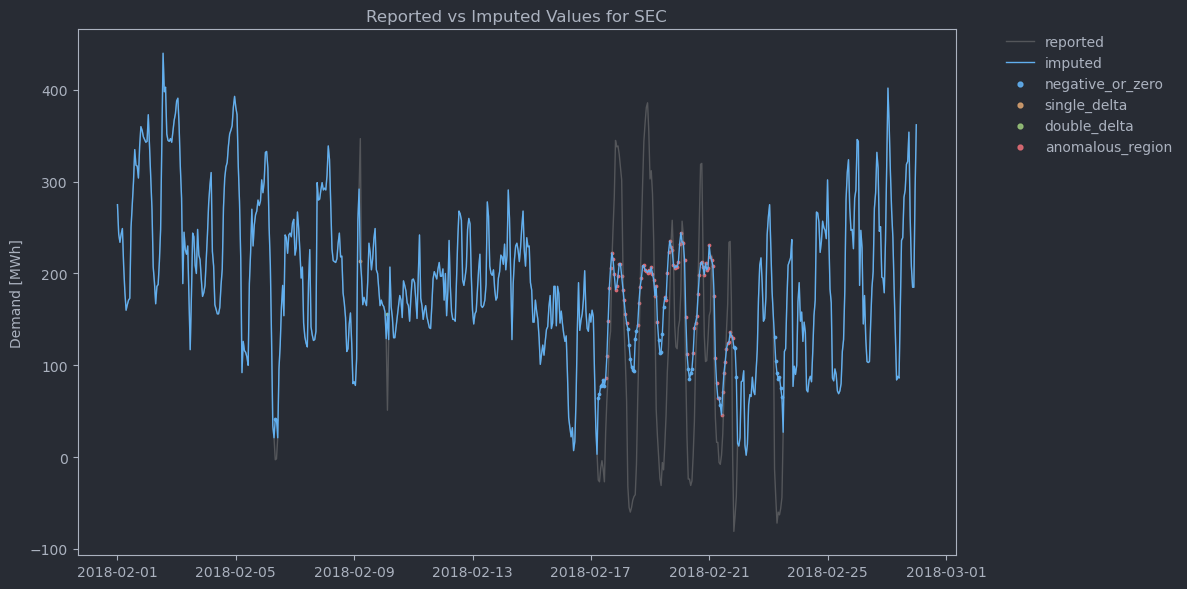

In [27]:
for month, ba_idx_vals in [
    ("2017-03-01", ("PACE")),
    ("2018-02-01", ("SEC")),
]:
    plot_imputation(
        eia930_ba_demand,
        idx_cols=ba_idx_cols,
        idx_vals=ba_idx_vals,
        start_date=month,
        end_date=pd.Timestamp(month) + MonthEnd(),
        reported_col="demand_reported_mwh",
        imputed_col="demand_imputed_pudl_mwh",
    )

In the top plot we see another common occurrence where we remove significant outliers from the reported data. In this case the outliers are so significant that it can be difficult to see the details in the remaining data, but it quite clear that the imputed values for these outliers are much more inline with the rest of the data for this timeframe.

In the second plot, we can see that the reported curve continually dips below zero in the heavily imputed section which begins around the 17th. Since negative demand does not make sense, these values get flagged as `negative_or_zero`, and the points between are considered an `anomalous_region`.

# Compare to Baseline Imputation
Next, we'll demonstrate how we used the baseline imputation referenced above to compare with our implementation. While our implementation is adapted from this reference, we've use a different underlying method for the actual imputation, so we don't expect our results to be exactly the same. Instead, we want to check that our results are not obviously worse, and that there are not any significant systemic differences between our results.

## Prepare Reference Data for Comparison
The reference data is published on zenodo [here](https://zenodo.org/records/14768167). Below we'll define a function that will load this data into a pandas DataFrame, then transform it to a structure equivalent to our own data.

In [13]:
def extract_baseline_imputation() -> pd.DataFrame:
    r = requests.get("https://zenodo.org/records/14768167/files/truggles/EIA_Cleaned_Hourly_Electricity_Demand_Data-v1.4.zip?download=1")
    f = BytesIO(r.content)
    subregions = []
    aggregations = []
    base_path = "truggles-EIA_Cleaned_Hourly_Electricity_Demand_Data-5c959df/data/"
    archive = zipfile.Path(f, at=base_path)
    for release in ["release_2020_Oct_include_subregions", "release_2025_Jan_include_subregions"]:
        # Get subregion data
        for path in (archive / release / "subregions_and_balancing_authorities").iterdir():
            if not path.name.endswith(".csv"):
                continue
            df = pd.read_csv(path.open())

            # Get subregion/ba
            stem = path.name.split(".")[0]
            name = stem.split("-")
            ba = name[0]
            subregion = None if len(name) == 1 else name[1]
            df["balancing_authority_code_eia"] = ba
            df["balancing_authority_subregion_code_eia"] = subregion

            subregions.append(df)

        # Get aggregated data
        if "2025" in release:
            for agg_level, agg_level_path in {
                "conus": "contiguous_US",
                "interconnect": "interconnects",
                "region": "regions",
            }.items():
                for path in (archive / release / agg_level_path).iterdir():
                    if not path.name.endswith(".csv"):
                        continue

                    df = pd.read_csv(path.open())
                    df["aggregation_level"] = agg_level
                    if agg_level == "conus":
                        df["aggregation_group"] = "conus"
                    elif agg_level == "interconnect":
                        group = path.name.split("_")[0].lower()
                        group = "ercot" if group == "texas" else group
                        df["aggregation_group"] = group
                    elif agg_level == "region":
                        df["aggregation_group"] = path.name.split(".")[0].lower()
                    aggregations.append(df)

    subregions_df = pd.concat(subregions).rename(columns={"cleaned demand (MW)": "baseline_demand_mwh"}).reset_index()
    subregions_df["datetime_utc"] = pd.to_datetime(subregions_df["date_time"])

    aggregated_df = pd.concat(aggregations).rename(
        columns={"cleaned demand (MW)": "baseline_demand_mwh", "raw demand (MW)": "raw_demand_mwh"}
    ).reset_index()
    aggregated_df["datetime_utc"] = pd.to_datetime(aggregated_df["date_time"])

    return (
        subregions_df[["datetime_utc", "baseline_demand_mwh", "balancing_authority_code_eia", "balancing_authority_subregion_code_eia"]],
        aggregated_df[["datetime_utc", "baseline_demand_mwh", "raw_demand_mwh", "aggregation_level", "aggregation_group"]]
    )

baseline_subregion_demand, baseline_aggregated_demand = extract_baseline_imputation()

## Merge PUDL Version with Baseline

In [14]:
comparison_df = eia930_subregion_demand.merge(
    baseline_subregion_demand,
    on=["datetime_utc", "balancing_authority_code_eia", "balancing_authority_subregion_code_eia"],
    how="inner"
)

## Implement function to visualize both imputation versions

In [15]:
def plot_compare_imputation(
    df: pd.DataFrame,
    idx_cols: list[str],
    idx_vals: tuple[Any],
    start_date: str,
    end_date: str,
    reported_col: str,
    timeseries_a: str,
    timeseries_b: str,
    time_col: str = "datetime_utc",
    ylabel: str = "Demand [MWh]",
):  # pragma: no cover
    """Plot two timeseries of the same information like demand for comparison."""
    filtered = _filter_df(df, idx_cols, idx_vals, start_date, end_date, time_col)

    # Plot reported
    plt.figure(figsize=(12, 6))
    plt.plot(
        filtered.index,
        filtered[reported_col],
        lw=1,
        color="gray",
        label="reported",
        alpha=0.5,
    )

    plt.plot(filtered.index, filtered[timeseries_a], lw=1, label=timeseries_a)
    plt.plot(filtered.index, filtered[timeseries_b], lw=1, label=timeseries_b, ls="--")
    plt.title(f"{timeseries_a} vs {timeseries_b} for {idx_vals}")
    plt.ylabel(ylabel)
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        borderaxespad=0.0,
    )
    plt.tight_layout()  # Adjust layout to make room for the legend
    plt.show()

## Plot Subregion Demand for Reference and PUDL Imputations
Below we'll plot the same regions of subregion demand data as shown above. In this case, however, we will overlay the baseline imputation on our imputation.

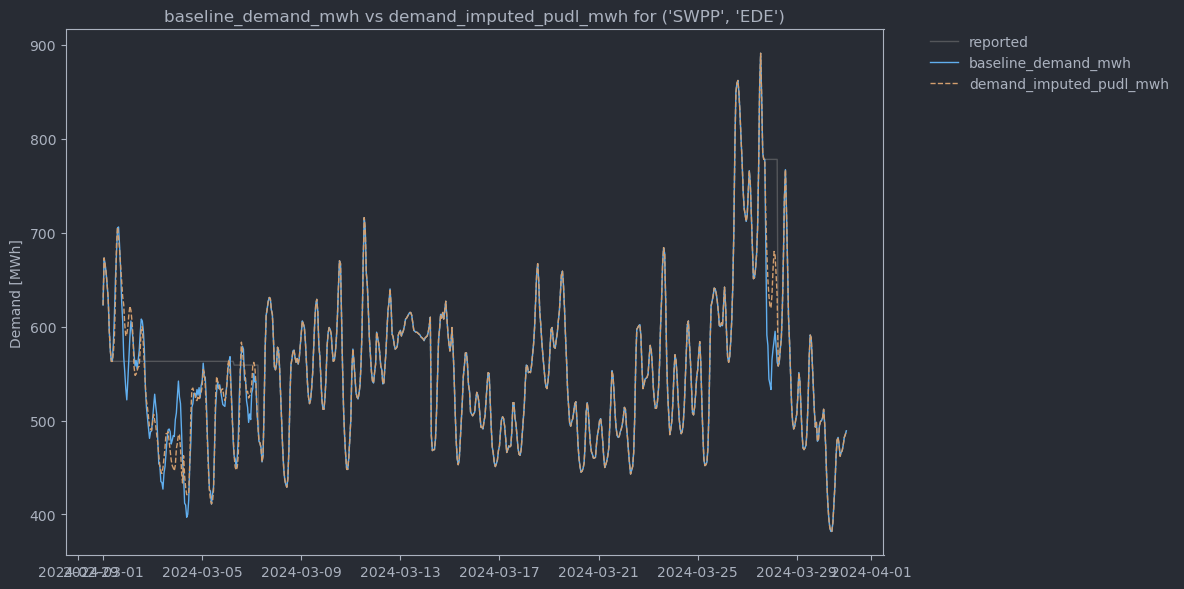

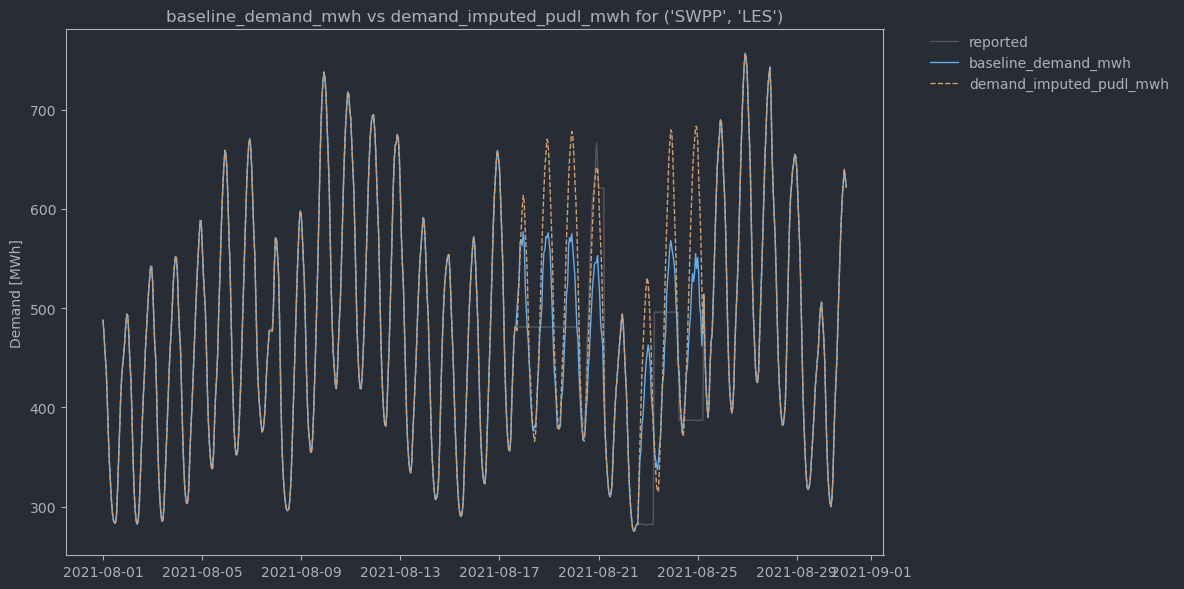

In [16]:
for month, subregion_idx_vals in [
    ("2024-03-01", ("SWPP", "EDE")),
    ("2021-08-01", ("SWPP", "LES")),
]:
    plot_compare_imputation(
        comparison_df,
        idx_cols=subregion_idx_cols,
        idx_vals=subregion_idx_vals,
        start_date=month,
        end_date=pd.Timestamp(month) + MonthEnd(),
        timeseries_a="baseline_demand_mwh",
        timeseries_b="demand_imputed_pudl_mwh",
        reported_col="demand_reported_mwh",
    )

Here we see that there are certainly differences in our results, but there is not any reason to immediately assume our results are worse than the reference, which for our purposes is all we're really looking for. Below, we'll take this line of investigation a step further to ensure that across the board there aren't any significant sytemic differences between our results.

## Look for Systemic Differences
While we expect there to be variation between our two imputations, it may be concerning if one implementation was consistently imputing larger or smaller values. To look for this type of systemic difference, we can compare the correlation between our imputations. 

In [18]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_correlation(
    df: pd.DataFrame,
    timeseries_x: str,
    timeseries_y: str,
    idx_cols: list[str],
    idx_vals: list[tuple[Any] | str] | None = None,
    xylim: tuple[float] | None = None,
    xlabel: str = "",
    ylabel: str = "",
    title: str = "",
    time_col: str = "datetime_utc",
    start_date: str | None = None,
    end_date: str | None = None,
    log: bool = True,
    legend: bool = True,
    alpha: float = 0.1,
):
    """Plot the correlation between two analogous time series."""
    plt.figure(figsize=(12, 12))

    # Generate a color palette using Matplotlib
    # Use the "tab10" colormap with the required number of colors
    cmap = cm.get_cmap("tab10", len(idx_vals))
    # Convert colors to hex format
    palette = [mcolors.to_hex(cmap(i)) for i in range(len(idx_vals))]
    color_map = {group: palette[i] for i, group in enumerate(idx_vals)}

    for idx in idx_vals:
        filtered = _filter_df(
            df,
            idx_cols=idx_cols,
            idx_vals=idx,
            start_date=start_date,
            end_date=end_date,
            time_col=time_col,
        )
        label = "-".join(str(idx)) if isinstance(idx, tuple) else str(idx)
        plt.scatter(
            filtered[timeseries_x],
            filtered[timeseries_y],
            s=0.1,
            alpha=alpha,
            label=label,
            color=color_map[idx],
        )

    if xylim is not None:
        plt.xlim(xylim)
        plt.ylim(xylim)
    if log:
        plt.xscale("log")
        plt.yscale("log")

    # Add some gridlines
    plt.grid(True, which="both", ls="--", lw=0.5, alpha=0.5)
    # Show line for perfect correlation where x == y
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    min_val = max(min(xlim), min(ylim))
    max_val = min(max(xlim), max(ylim))
    plt.plot(
        [min_val, max_val],
        [min_val, max_val],
        linestyle="--",
        color="gray",
        linewidth=0.5,
    )

    if legend:
        leg = plt.legend(
            loc="upper left",
            scatterpoints=3,
            markerscale=10,
            labelspacing=1.2,
        )
        for lh in leg.legend_handles:
            lh.set_alpha(1.0)

    # Label the plot
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_50065/1230349378.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(idx_vals))


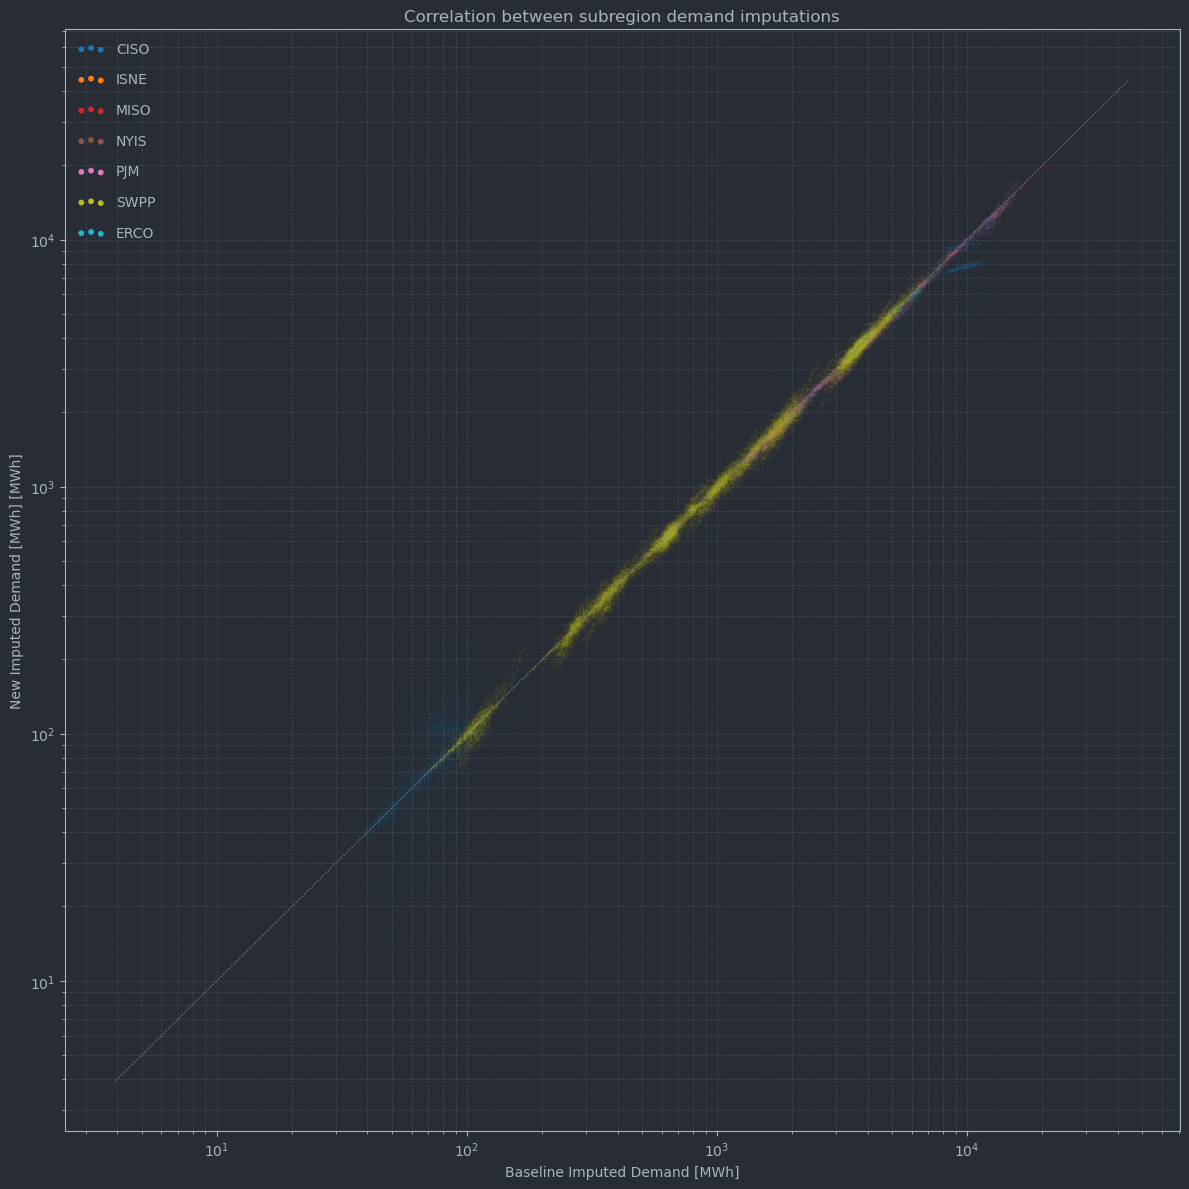

In [19]:
all_bas = list(comparison_df["balancing_authority_code_eia"].unique())

plot_correlation(
    comparison_df[comparison_df.demand_imputed_pudl_mwh_imputation_code.notnull()].reset_index(),
    idx_cols=["balancing_authority_code_eia"],
    idx_vals=all_bas,
    timeseries_x="baseline_demand_mwh",
    timeseries_y="demand_imputed_pudl_mwh",
    xlabel="Baseline Imputed Demand [MWh]",
    ylabel="New Imputed Demand [MWh] [MWh]",
    title="Correlation between subregion demand imputations",
    alpha=0.1,
)

In this plot, each point represents a single imputed value with the baseline imputation on the X-axis, and our new imputation on the Y-axis. We expect to see the points generally follow the dotted line if there is a degree of correlation. Overall this appears to be generally, and while there is variation, there's not any obvious signs of a systemic bias. That being said, we can take a closer look at some of the BA's which show more variation in the imputation so get a better sense for what's going on here.

/tmp/ipykernel_50065/1230349378.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(idx_vals))


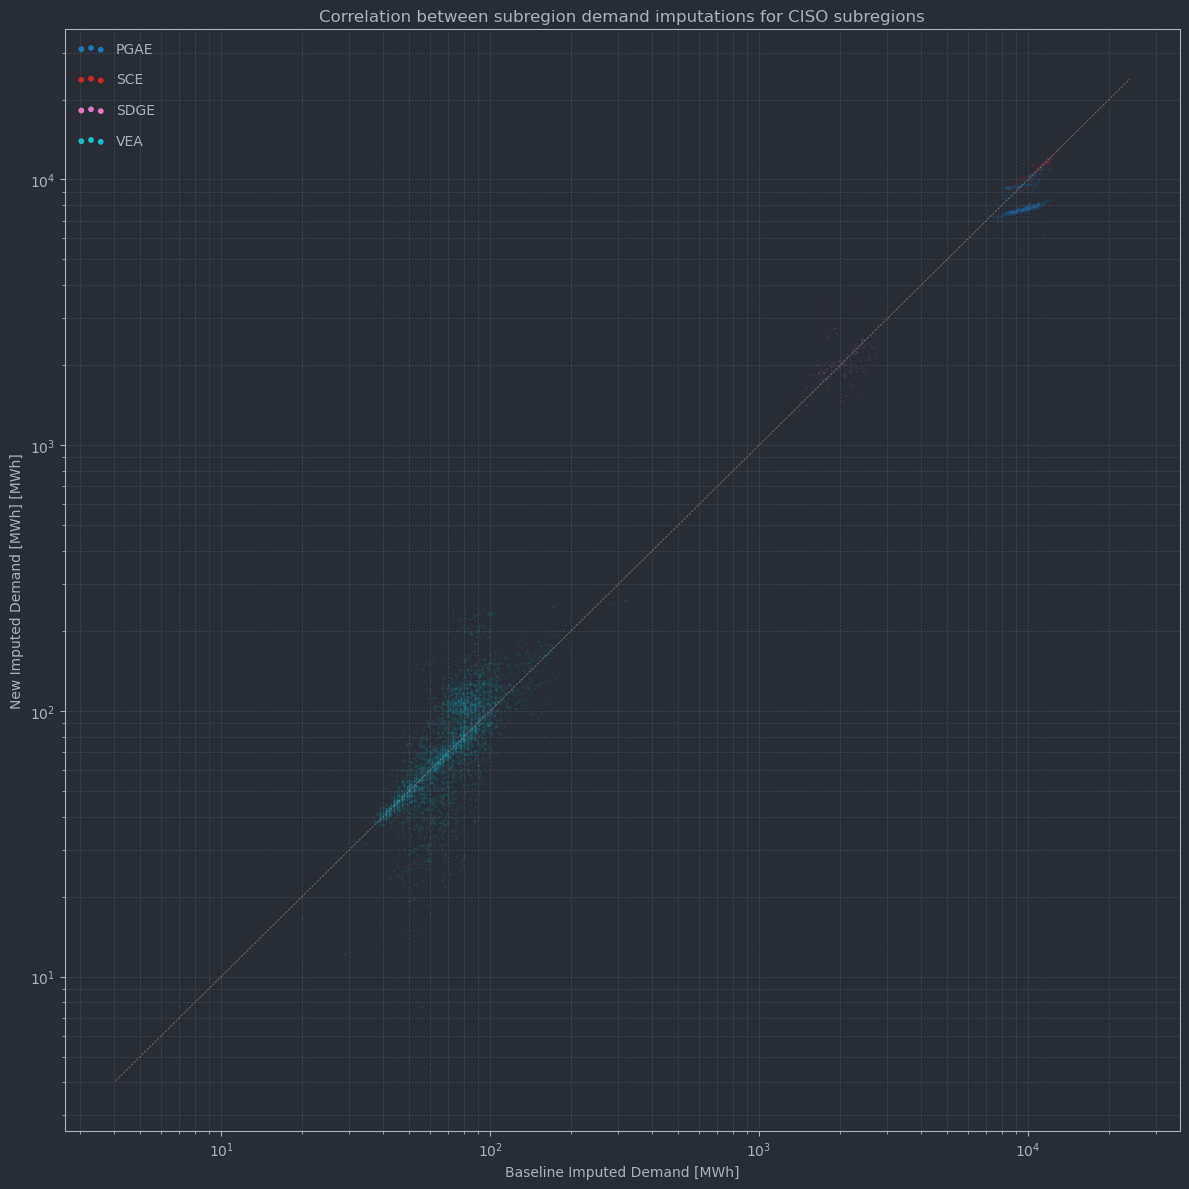

In [20]:
ba = "CISO"
selection = comparison_df[comparison_df["balancing_authority_code_eia"] == ba]
all_subregions = list(selection["balancing_authority_subregion_code_eia"].unique())

plot_correlation(
    selection[selection.demand_imputed_pudl_mwh_imputation_code.notnull()].reset_index(),
    idx_cols=["balancing_authority_subregion_code_eia"],
    idx_vals=all_subregions,
    timeseries_x="baseline_demand_mwh",
    timeseries_y="demand_imputed_pudl_mwh",
    xlabel="Baseline Imputed Demand [MWh]",
    ylabel="New Imputed Demand [MWh] [MWh]",
    title="Correlation between subregion demand imputations for CISO subregions",
    alpha=0.2,
)

Looking at this plot, there's a couple portions of data which stand out as potentially interesting. First, there seems to be a high degree of variation in the VEA data, which, while it doesn't indicate a systemic bias, it is out of line with the other subregions. The other area of interest is PGAE, which has a segment consistently below the correlation line, which could be indicative of something more systemic.

To investigate these sections, let's look at the relative imputation rates across all CISO subregions to see if there's anything unique going on with these subregions. To do this, we'll use the `get_imputation_rate` function, but this time we won't limit the range on the imputation rate, and we'll use `time_period="year"` to see imputation rate by year.

In [21]:
ciso_imputation_rate = get_imputation_rate(
    eia930_subregion_demand,
    idx_cols=subregion_idx_cols,
    num_samples=0,
    min_imputation_rate=0.0,
    max_imputation_rate=1.0,
    time_period="year"
)
ciso_imputation_rate[
    ciso_imputation_rate.balancing_authority_code_eia == "CISO"
].sort_values(by="imputation_rate", ascending=False)

,balancing_authority_code_eia,balancing_authority_subregion_code_eia,year,imputation_rate
23,CISO,VEA,2024-12-31,0.132058
19,CISO,VEA,2020-12-31,0.091872
0,CISO,PGAE,2019-12-31,0.079534
18,CISO,VEA,2019-12-31,0.075648
22,CISO,VEA,2023-12-31,0.051484
20,CISO,VEA,2021-12-31,0.019521
21,CISO,VEA,2022-12-31,0.014840
12,CISO,SDGE,2019-12-31,0.007199
6,CISO,SCE,2019-12-31,0.007085
11,CISO,SCE,2024-12-31,0.005578


From these results, we see that VEA has the highest rates of imputation across the board other than a single year of PGAE data. It seems likely that the messiness VEA data is contributing to the higher levels of variation we're seeing. Another likely contributing factor is that VEA demand has a much lower magnitude, so on this log-plot similar levels of absolute variation will appear much more significant at these lower magnitudes.

Now looking at PGAE, we see that this data typically has quite low rates of imputation other than 2019. Given this, it seems likely the strange segment is coming from this year, so lets take a closer look. Below we'll plot a comparison of our imputation vs the baseline for PGAE 2019 data.

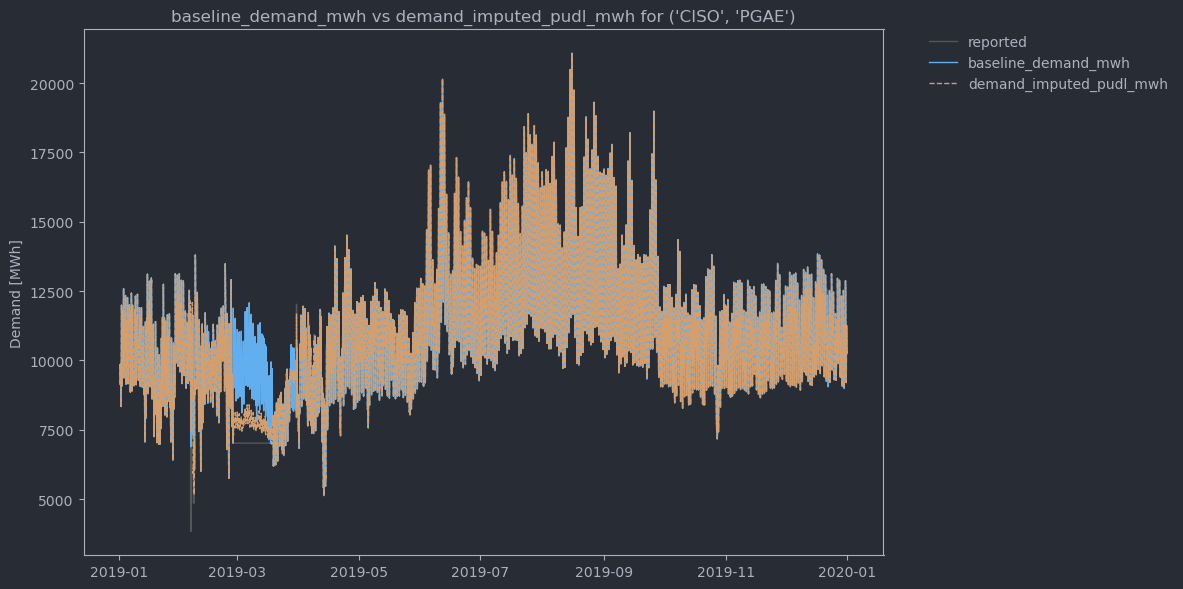

In [22]:
plot_compare_imputation(
    comparison_df,
    idx_cols=subregion_idx_cols,
    idx_vals=("CISO", "PGAE"),
    start_date="2019-01-01",
    end_date="2019-12-31",
    timeseries_a="baseline_demand_mwh",
    timeseries_b="demand_imputed_pudl_mwh",
    reported_col="demand_reported_mwh",
)

Plotting an entire year like this is difficult to interpret, but we can clearly see there's a section around March where there's some significant differences between our results. Let's zoom in on this section to get a better sense for what's going on.

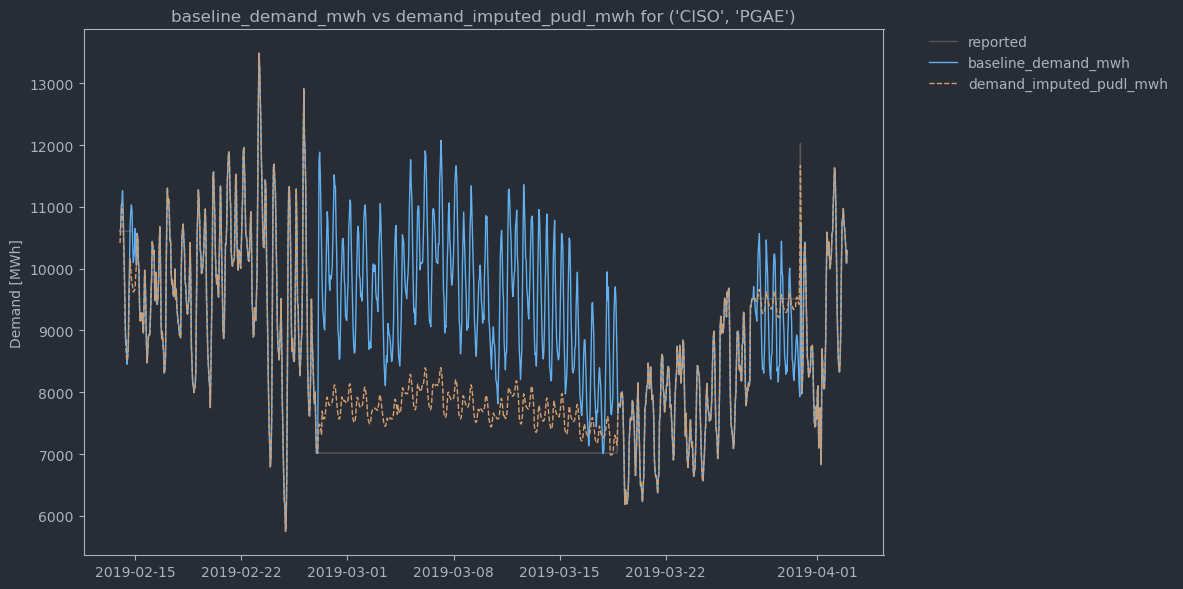

In [23]:
plot_compare_imputation(
    comparison_df,
    idx_cols=subregion_idx_cols,
    idx_vals=("CISO", "PGAE"),
    start_date="2019-02-14",
    end_date="2019-04-02",
    timeseries_a="baseline_demand_mwh",
    timeseries_b="demand_imputed_pudl_mwh",
    reported_col="demand_reported_mwh",
)

Here we see over half a month where all of the data is imputed, and our imputation is consistently lower than the baseline. This matches up quite closely with what we see in the correlation plot, and seems likely to explain it. This is probably the most concerning example of our imputation that we've seen. Clearly, the baseline imputation looks much more consistent with the reported data. It seems that something about the specific circumstances of this case have caused our imputation method to struggle. We're trying to identify the exact cause, and will update our method if we're able to do so. In the meantime we've also spent some time investigating for other similar cases, and so far have not identified any. If you use this data and find discover any issues or concerns, please create an [issue](https://github.com/catalyst-cooperative/pudl/issues/) with details in the description.